# 라이브러리 설치

In [75]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

import gensim
import gensim.corpora as corpora
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import pyLDAvis 
import pyLDAvis.gensim as gensimvis 

from wordcloud import WordCloud, STOPWORDS 
from scipy.sparse import hstack
from collections import Counter
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestRegressor  # 랜덤 포레스트 회귀 모델
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# NLTK 불용어 가져오기
import nltk
# NLTK 초기화
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 경고 출력 제외
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트를 설정하여 시각화에 한글이 깨지지 않도록 설정
plt.rcParams['font.family'] = 'gulim'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 데이터 불러오기

In [76]:
df = pd.read_csv("/Users/iyuseon/Downloads/archive (2)/chatgpt_sentiment.csv")

# 기본 통계 확인

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975450 entries, 0 to 975449
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Text             975027 non-null  object 
 1   negative         975450 non-null  float64
 2   neutral          975450 non-null  float64
 3   positive         975450 non-null  float64
 4   predicted_label  975450 non-null  object 
 5   date             975450 non-null  object 
 6   likes            975450 non-null  int64  
 7   location         705265 non-null  object 
 8   followers        975450 non-null  int64  
 9   following        975450 non-null  int64  
 10  retweets         975450 non-null  int64  
 11  replies          975450 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 89.3+ MB


In [78]:
df.shape

(975450, 12)

In [79]:
df.describe()

,negative,neutral,positive,likes,followers,following,retweets,replies
count,975450.000000,975450.000000,975450.000000,975450.000000,9.754500e+05,9.754500e+05,975450.000000,975450.000000
mean,0.224028,0.437321,0.338650,11.961189,3.231735e+04,1.573738e+03,1.765541,1.114315
std,0.349075,0.374737,0.377395,355.771275,7.281230e+05,9.618419e+03,57.776420,36.731214
min,0.001543,0.005018,0.003674,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.006844,0.052123,0.018617,0.000000,8.600000e+01,1.480000e+02,0.000000,0.000000
50%,0.024687,0.355728,0.116684,1.000000,4.390000e+02,4.600000e+02,0.000000,0.000000
75%,0.254022,0.846569,0.746904,2.000000,2.041000e+03,1.214000e+03,0.000000,1.000000
max,0.986359,0.993227,0.990427,111653.000000,1.287402e+08,1.526451e+06,13072.000000,19942.000000


# 전처리

In [80]:
# date를 년/월/일로 분리
df['date'] = pd.to_datetime(df['date'])

In [81]:
# Text 컬럼의 결측값 제거
df = df[df['Text'].notnull()]

In [82]:
# location 컬럼에서 결측값을 "Unknown"으로 대체
df['location'] = df['location'].fillna("Unknown")

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 975027 entries, 0 to 975449
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   Text             975027 non-null  object             
 1   negative         975027 non-null  float64            
 2   neutral          975027 non-null  float64            
 3   positive         975027 non-null  float64            
 4   predicted_label  975027 non-null  object             
 5   date             975027 non-null  datetime64[ns, UTC]
 6   likes            975027 non-null  int64              
 7   location         975027 non-null  object             
 8   followers        975027 non-null  int64              
 9   following        975027 non-null  int64              
 10  retweets         975027 non-null  int64              
 11  replies          975027 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(3), int64(5), object(3)
memo

# 필터링

데이터 크기가 너무 커서 분석에 어려움이 있기 때문에 실행

In [84]:
df = df[(df['positive'] > 0.8) | (df['negative'] > 0.8)]

In [85]:
df = df[(df['likes'] > 10) | (df['retweets'] > 5) | (df['replies'] > 3)]

# 텍스트 분석 함수 정의 

In [86]:
# 기본 불용어
stop_words = set(stopwords.words('english'))

# 트윗 전용 추가 불용어
tweet_stopwords = {'rt', 'via', 'amp', 'http', 'https', 'www', 'com', 'co', 'u', 'us',
                   'like', 'follow', 'followers', 'retweet', 'tweet', 'tweets', 'reply', 'replies',
                   'chatgpt', 'openai', 'open', 'chat', 'gpt', 'im', 'ive', 'cant', 'ai', 'get', 'use', 'ask', 'try', 'open'}

# 통합된 불용어 리스트
stop_words.update(tweet_stopwords)

In [87]:
# 변수 초기화
lemmatizer = WordNetLemmatizer()

# 텍스트 전처리 함수 정의
def preprocess_text(text_data, get_lemma=True, tags=(), stop_words=[]):
    # 소문자 변경
    text_data = text_data.lower()
    # URL 제거
    text_data = re.sub(r'((www\.\S+)|(https?://\S+))', r"", text_data)
    # HTML 태그 제거
    text_data = re.sub(r'<[^>]+>', r'', text_data)
    # 숫자 제거
    text_data = re.sub(r'[0-9]\S+', r'', text_data)
    # 문장부호 제거
    text_data = text_data.translate(str.maketrans("", "", string.punctuation))
    # 토큰화
    tokens = word_tokenize(text_data)
    # 불용어 제거
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # 래마타이즈
    if get_lemma:
        tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]  # 동사 형태로 lemmatize
        tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]  # 명사 형태로 lemmatize
    # POS 필터
    if tags:
        tokens = [word for word, pos in nltk.pos_tag(tokens) if pos.startswith(tags)]
    return " ".join(tokens)

# Sentence to Word 함수
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

# 공백 제거 함수 정의
def remove_extra_spaces(text_data):
    # 단어별로 분리된 텍스트에서 각 단어의 앞뒤 공백을 제거하고 다시 결합
    return " ".join([word.strip() for word in text_data.split()])

# 품사 태그 설정
TAGS = ("JJ", "NN", "RB", "VB")

In [88]:
try:
    df['cleaned_text'] = df.apply(
        lambda x: preprocess_text(str(x['Text']), get_lemma=True, tags=TAGS, stop_words=stop_words), axis=1
    )
    print("cleaned_text 컬럼이 생성되었습니다.")
except Exception as e:
    print(f"cleaned_text 생성 중 오류 발생: {e}")

# 전처리된 데이터 예시 출력
if 'cleaned_text' in df.columns:
    print(df[['cleaned_text']].head())
else:
    print("cleaned_text 컬럼이 생성되지 않았습니다.")

cleaned_text 컬럼이 생성되었습니다.
                                          cleaned_text
22                      bbig get chatgpt openai snitch
44   hour long conversation chatgpt math optimizati...
85   great see many people person online talk chatg...
119  check chip ai respond fast give really indepth...
144  nice list definitely watch octane x release ap...


In [89]:
# cleaned_text 컬럼 전처리
def preprocess_dataset(df, tags, stop_words):
    df['cleaned_text'] = df.apply(
        lambda x: preprocess_text(x['Text'], get_lemma=True, tags=tags, stop_words=stop_words), axis=1
    )
    return df

In [90]:
# 전처리된 데이터 예시 출력
print(df[['cleaned_text']].head())

                                          cleaned_text
22                      bbig get chatgpt openai snitch
44   hour long conversation chatgpt math optimizati...
85   great see many people person online talk chatg...
119  check chip ai respond fast give really indepth...
144  nice list definitely watch octane x release ap...


In [91]:
df.head()

,Text,negative,neutral,positive,predicted_label,date,likes,location,followers,following,retweets,replies,cleaned_text
22,BBIG Just got ChatGPT OpenAI to snitch on its...,0.978697,0.013870,0.007433,negative,2023-02-10 23:57:31+00:00,22,Unknown,8417,1834,4,2,bbig get chatgpt openai snitch
44,Had an hour long conversation with ChatGPT abo...,0.006905,0.062680,0.930414,positive,2023-02-10 23:55:26+00:00,831,Nintendo Jail,28671,4,20,25,hour long conversation chatgpt math optimizati...
85,Great to see so many people in person and onli...,0.006372,0.010792,0.982836,positive,2023-02-10 23:52:18+00:00,22,"Adelaide, South Australia",472,719,4,1,great see many people person online talk chatg...
119,Check out CHIP. The AI responds fast and gives...,0.008253,0.076214,0.915533,positive,2023-02-10 23:49:14+00:00,10,Los Angeles,1802,4006,6,1,check chip ai respond fast give really indepth...
144,"Nice list, is definitely one to watch! - Octan...",0.003453,0.027268,0.969279,positive,2023-02-10 23:46:40+00:00,12,Unknown,680,865,1,0,nice list definitely watch octane x release ap...


In [92]:
# 공백 제거
df['cleaned_text'] = df['cleaned_text'].apply(remove_extra_spaces)

# 결과 확인
print(df[['cleaned_text']].head())

                                          cleaned_text
22                      bbig get chatgpt openai snitch
44   hour long conversation chatgpt math optimizati...
85   great see many people person online talk chatg...
119  check chip ai respond fast give really indepth...
144  nice list definitely watch octane x release ap...


In [93]:
# 컬럼 다시 전처리
df['cleaned_text'] = df.apply(lambda x: preprocess_text(x['cleaned_text'], get_lemma=True, tags=TAGS, stop_words=stop_words), axis=1)

# 전처리된 데이터 예시 출력
print(df[['cleaned_text']].head())

                                          cleaned_text
22                      bbig get chatgpt openai snitch
44   hour long conversation chatgpt math optimizati...
85   great see many people person online talk chatg...
119  check chip ai respond fast give really indepth...
144  nice list definitely watch octane x release ap...


다시 전처리 실행하는 이유: 'apple', ' apple', 'apple '와 같이 공백으로 인해 다른 단어로 인식 한 경우를 없애기 위해

In [94]:
# 텍스트를 리스트로 변환
dataset = df['cleaned_text'].values.tolist()
data_words = list(sent_to_words(dataset))
print(data_words[:1])

[['bbig', 'get', 'chatgpt', 'openai', 'snitch']]


In [95]:
# 결측치 제거 (빈 문서(길이가 0인 문서)를 제거)
data_words = [doc for doc in data_words if len(doc)>0]
print(data_words[:1])

[['bbig', 'get', 'chatgpt', 'openai', 'snitch']]


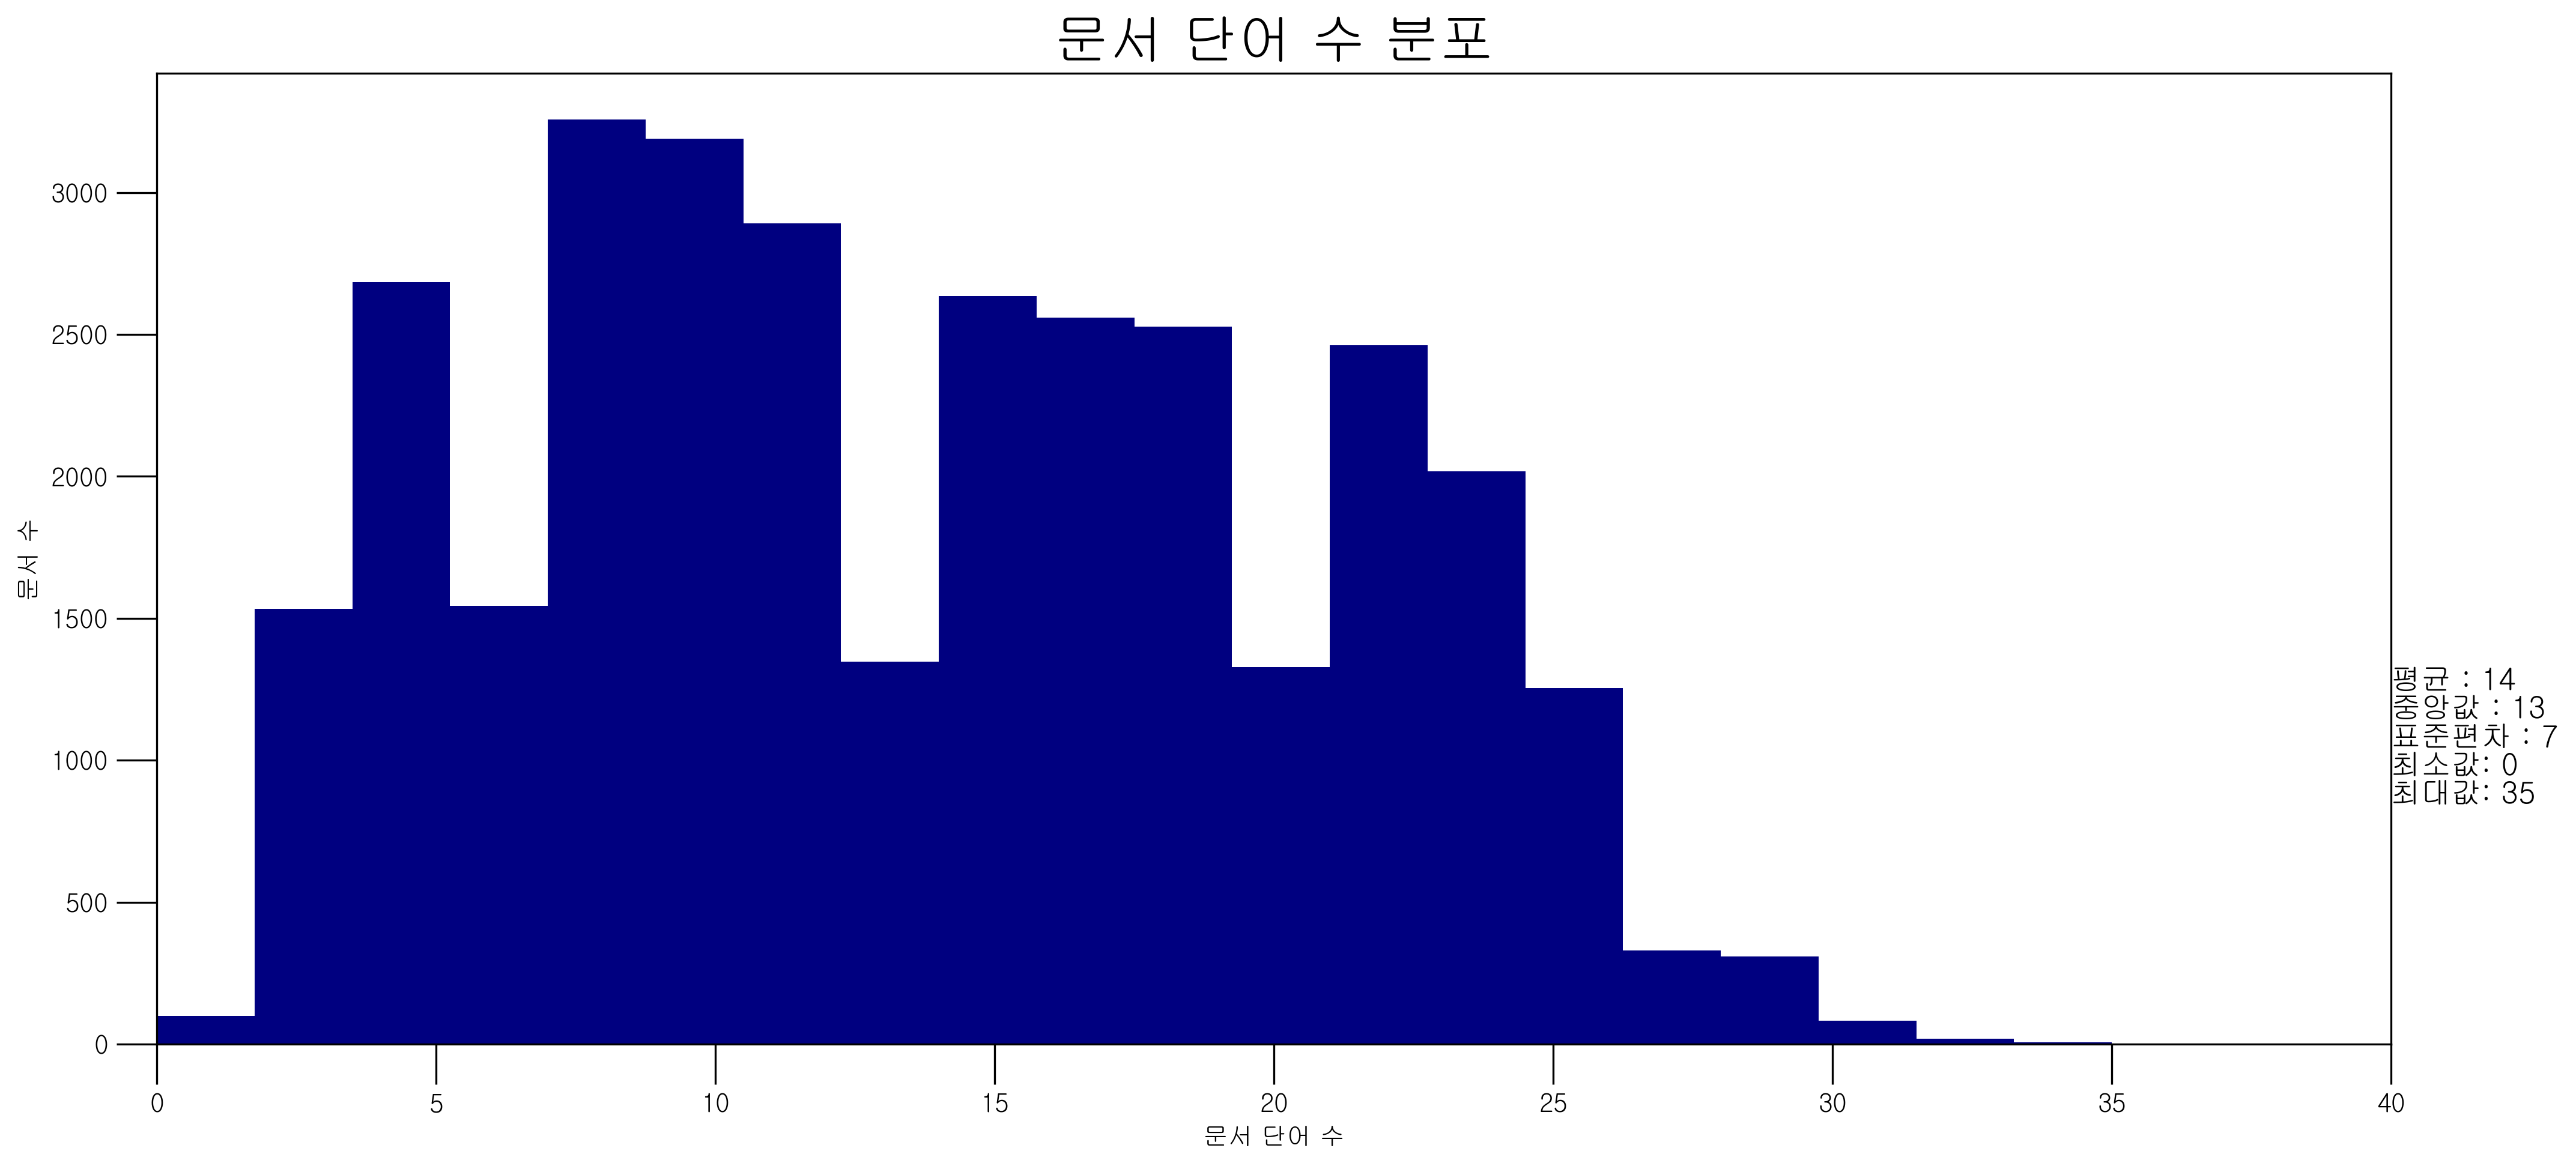

In [96]:
# 문서 길이 분포 시각화 함수
def plot_doc_length_distribution(df_dominant_topic, title):
    doc_lens = [len(d.split()) for d in df_dominant_topic]
    plt.figure(figsize=(16, 7), dpi=300)
    plt.hist(doc_lens, bins=20, color='navy')
    plt.text(40, 1250, "평균 : " + str(round(np.mean(doc_lens))), fontsize=12)
    plt.text(40, 1150, "중앙값 : " + str(round(np.median(doc_lens))), fontsize=12)
    plt.text(40, 1050, "표준편차 : " + str(round(np.std(doc_lens))), fontsize=12)
    plt.text(40, 950, "최소값: " + str(round(np.min(doc_lens))), fontsize=12)
    plt.text(40, 850, "최대값: " + str(round(np.max(doc_lens))), fontsize=12)
    plt.gca().set(xlim=(0, 40), ylabel='문서 수', xlabel='문서 단어 수')
    plt.tick_params(size=16)
    plt.title(title, fontdict=dict(size=22))
    plt.show()

plot_doc_length_distribution(df['cleaned_text'], '문서 단어 수 분포')

In [97]:
# N-그램 모델 처리
# 빅램(bigram)과 트라이그램(trigram) 모델을 생성하여 연속된 단어 조합을 학습
def process_ngram(data_words):
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    data_words = [bigram_mod[doc] for doc in data_words]
    data_words = [trigram_mod[bigram_mod[doc]] for doc in data_words]
    
    return data_words

In [98]:
# 문서를 단어 리스트로 변환
documents = [text.split() for text in df['cleaned_text']]

In [99]:
# 빅램과 트라이그램이 적용된 단어 리스트를 반환
documents = process_ngram(documents)

In [100]:
# 딕셔너리 크기 축소 함수
# Counter를 사용하여 전체 문서에서 특정 단어의 등장 횟수 체크
# 최소 등장 횟수 기준 이하의 단어를 딕셔너리에서 제거
def filter_dictionary_by_count(min_count, documents, dictionary):
    word_counter = Counter((word for words in documents for word in words))
    removal_word_idxs = {
        dictionary.token2id[word] for word, count in word_counter.items() if count < min_count
    }
    dictionary.filter_tokens(removal_word_idxs)
    dictionary.compactify()
    return dictionary

In [101]:
# 빈 문서 제거
documents = [doc for doc in documents if isinstance(doc, list) and doc]

In [102]:
# Gensim 모델링을 위한 Dictionary 생성
dictionary = corpora.Dictionary(documents)

# 카운터 사용해서 딕셔너리 크기 축소
dictionary = filter_dictionary_by_count(3, documents, dictionary)

# dictionary 내 단어만 남긴 documents 필터링
filtered_documents = [[word for word in doc if word in dictionary.token2id] for doc in documents]

In [103]:
# 말뭉치 생성
corpus = [dictionary.doc2bow(text) for text in documents if text]
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


# 토픽 모델링 (LDA)

In [104]:
# LDA 모델을 학습 및 일관성 점수를 계산하여 최적의 토픽 수 서치
def compute_coherence_values(dictionary, corpus, texts, k_values, passes_list): 
    results = []
    for num_topics in k_values: 
        for passes in passes_list:
            # Train LDA model
            lda_model = gensim.models.LdaModel( corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42,passes=passes)
            # Compute coherence score 
            coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')

            coherence_score = coherence_model.get_coherence() 
            results.append((num_topics, passes, coherence_score)) 
            print(f"Topics: {num_topics}, Passes: {passes}, Coherence:{coherence_score:.4f}") 
    return results

In [105]:
# 다양한 토픽 수와 패스를 설정해 LDA 모델 학습 시 사용
k_values = range(2, 6, 2)  # Number of topics (2, 4) 6,8 도 진행해봤으나 시간이 너무 오래 걸림림
passes_list = [10, 20, 30]  # Passes (모델 학습 시 반복 횟수)

# LDA 모델을 학습하고 일관성 점수를 계산
results = compute_coherence_values(dictionary, corpus, documents, k_values, passes_list)

Topics: 2, Passes: 10, Coherence:0.3892
Topics: 2, Passes: 20, Coherence:0.3962
Topics: 2, Passes: 30, Coherence:0.3962
Topics: 4, Passes: 10, Coherence:0.4258
Topics: 4, Passes: 20, Coherence:0.4202
Topics: 4, Passes: 30, Coherence:0.4211


일관성 점수가 높을수록 해당 토픽 모델이 더 적합함을 의미  

Topics: 4, Passes: 10, Coherence:0.4258 이 가장 베스트로 나옴옴

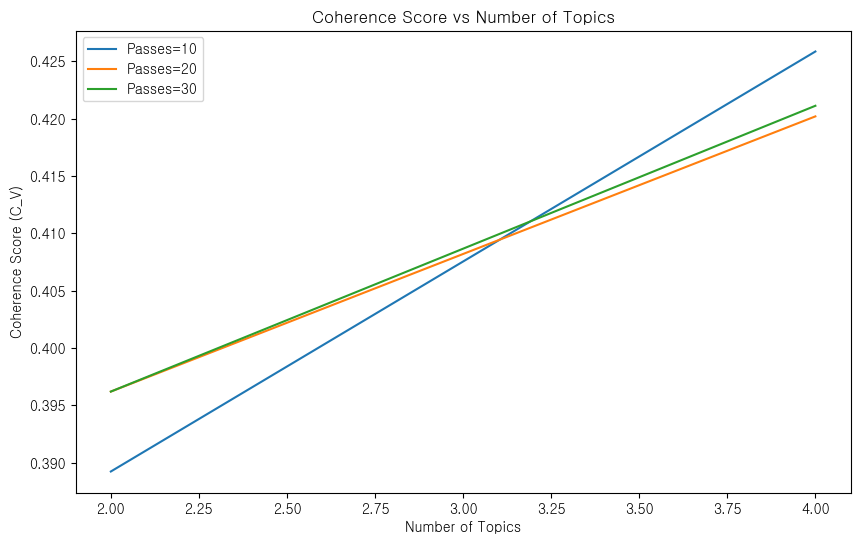

In [106]:
# 일관성 점수를 계산한 결과 시각화
results_df = pd.DataFrame(results, columns=["Num_Topics", "Passes", "Coherence"])

plt.figure(figsize=(10, 6)) 
for passes in passes_list:
    subset = results_df[results_df["Passes"] == passes] 
    plt.plot(subset["Num_Topics"], subset["Coherence"], label=f'Passes={passes}')
plt.title('Coherence Score vs Number of Topics') 
plt.xlabel('Number of Topics') 
plt.ylabel('Coherence Score (C_V)')  
plt.legend()
plt.show()

In [107]:
# 최적의 토픽 수와 패스를 사용하여 LDA 모델 학습
# 일관성 점수가 가장 높은 조합 선택
optimal_num_topics, optimal_passes, _ = max(results, key=lambda x: x[2])
final_lda_model = gensim.models.LdaModel( corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics, passes=optimal_passes, random_state=42)

for idx, topic in final_lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.072*"chatgpt" + 0.033*"ask" + 0.028*"write" + 0.016*"code" + 0.014*"use" + 0.013*"question" + 0.013*"prompt" + 0.012*"good" + 0.011*"answer" + 0.010*"pretty"
Topic 1: 0.086*"chatgpt" + 0.022*"im" + 0.017*"try" + 0.017*"get" + 0.014*"go" + 0.012*"think" + 0.012*"use" + 0.011*"see" + 0.010*"time" + 0.010*"thing"
Topic 2: 0.066*"chatgpt" + 0.014*"ai" + 0.010*"use" + 0.010*"write" + 0.009*"student" + 0.009*"make" + 0.008*"think" + 0.007*"people" + 0.007*"seem" + 0.006*"say"
Topic 3: 0.072*"chatgpt" + 0.043*"ai" + 0.018*"new" + 0.016*"openai" + 0.015*"google" + 0.010*"tool" + 0.009*"search" + 0.008*"release" + 0.008*"model" + 0.007*"future"


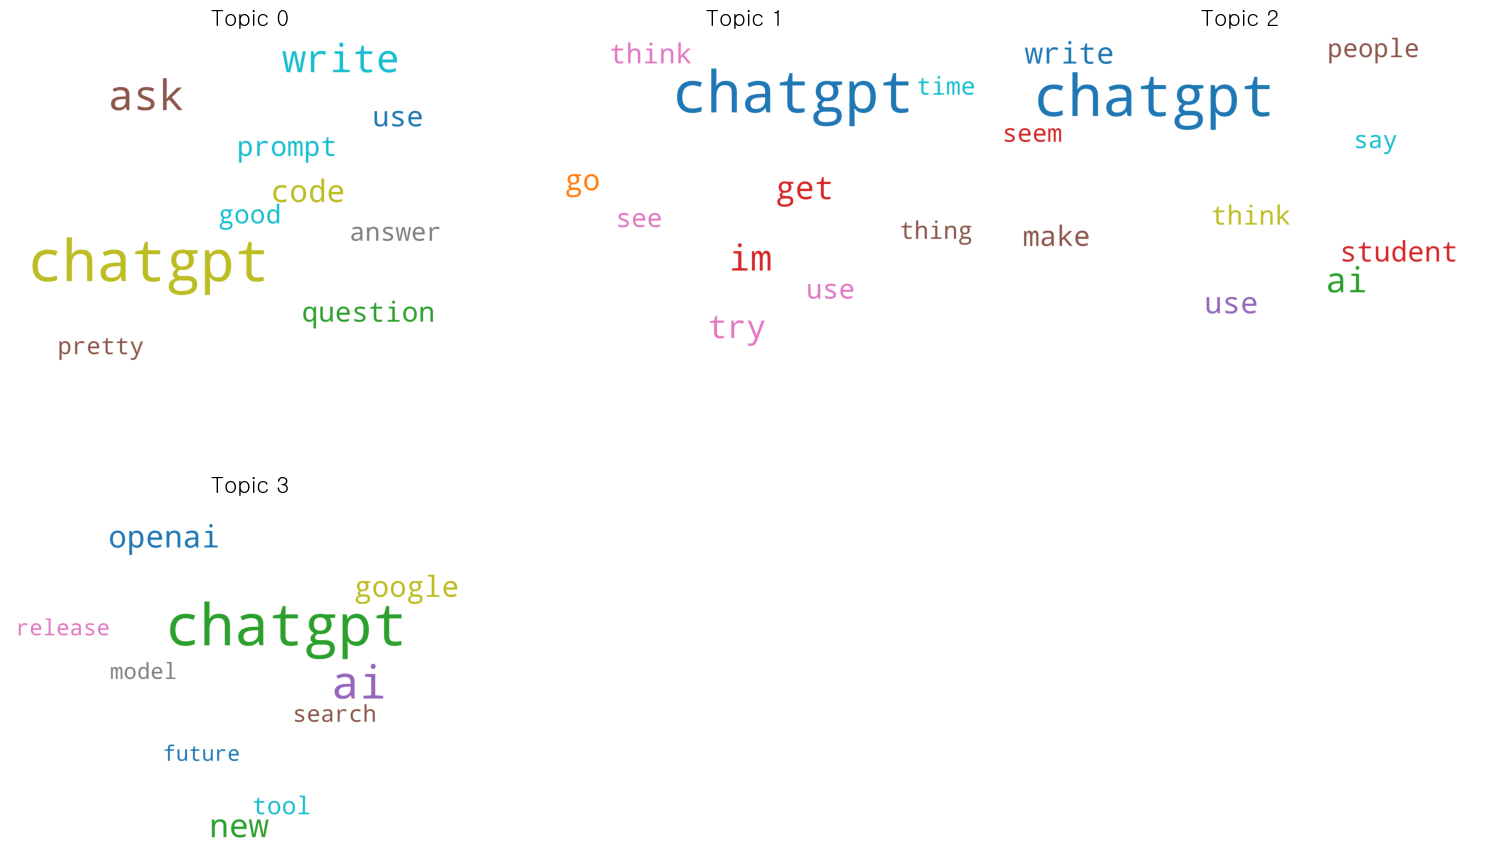

In [108]:
# 워드클라우드 생성
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words, background_color='white', width=2500, height=1800, max_words=30, colormap='tab10', prefer_horizontal=1.0)

topics = final_lda_model.show_topics(formatted=False)
num_topics = len(topics)  # 실제 토픽 개수 확인

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(min(num_topics, len(axes))):  # 오류 방지: 실제 토픽 개수보다 많은 인덱스를 참조하지 않도록 조정
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    axes[i].imshow(cloud)
    axes[i].set_title(f'Topic {i}', fontdict=dict(size=16))
    axes[i].axis('off')

# 남은 빈 서브플롯 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

In [109]:
# 토픽 키워드의 단어 수
topics = final_lda_model.show_topics(formatted=False) 
data_flat = [w for w_list in documents for w in w_list] 
counter = Counter(data_flat)
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
df2 = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 
df2

,word,topic_id,importance,word_count
0,chatgpt,0,0.071701,30290
1,ask,0,0.032879,2946
2,write,0,0.028209,4225
3,code,0,0.016459,1118
4,use,0,0.013701,5470
5,question,0,0.013221,1328
6,prompt,0,0.013196,1025
7,good,0,0.011641,1787
8,answer,0,0.011063,1508
9,pretty,0,0.009686,737


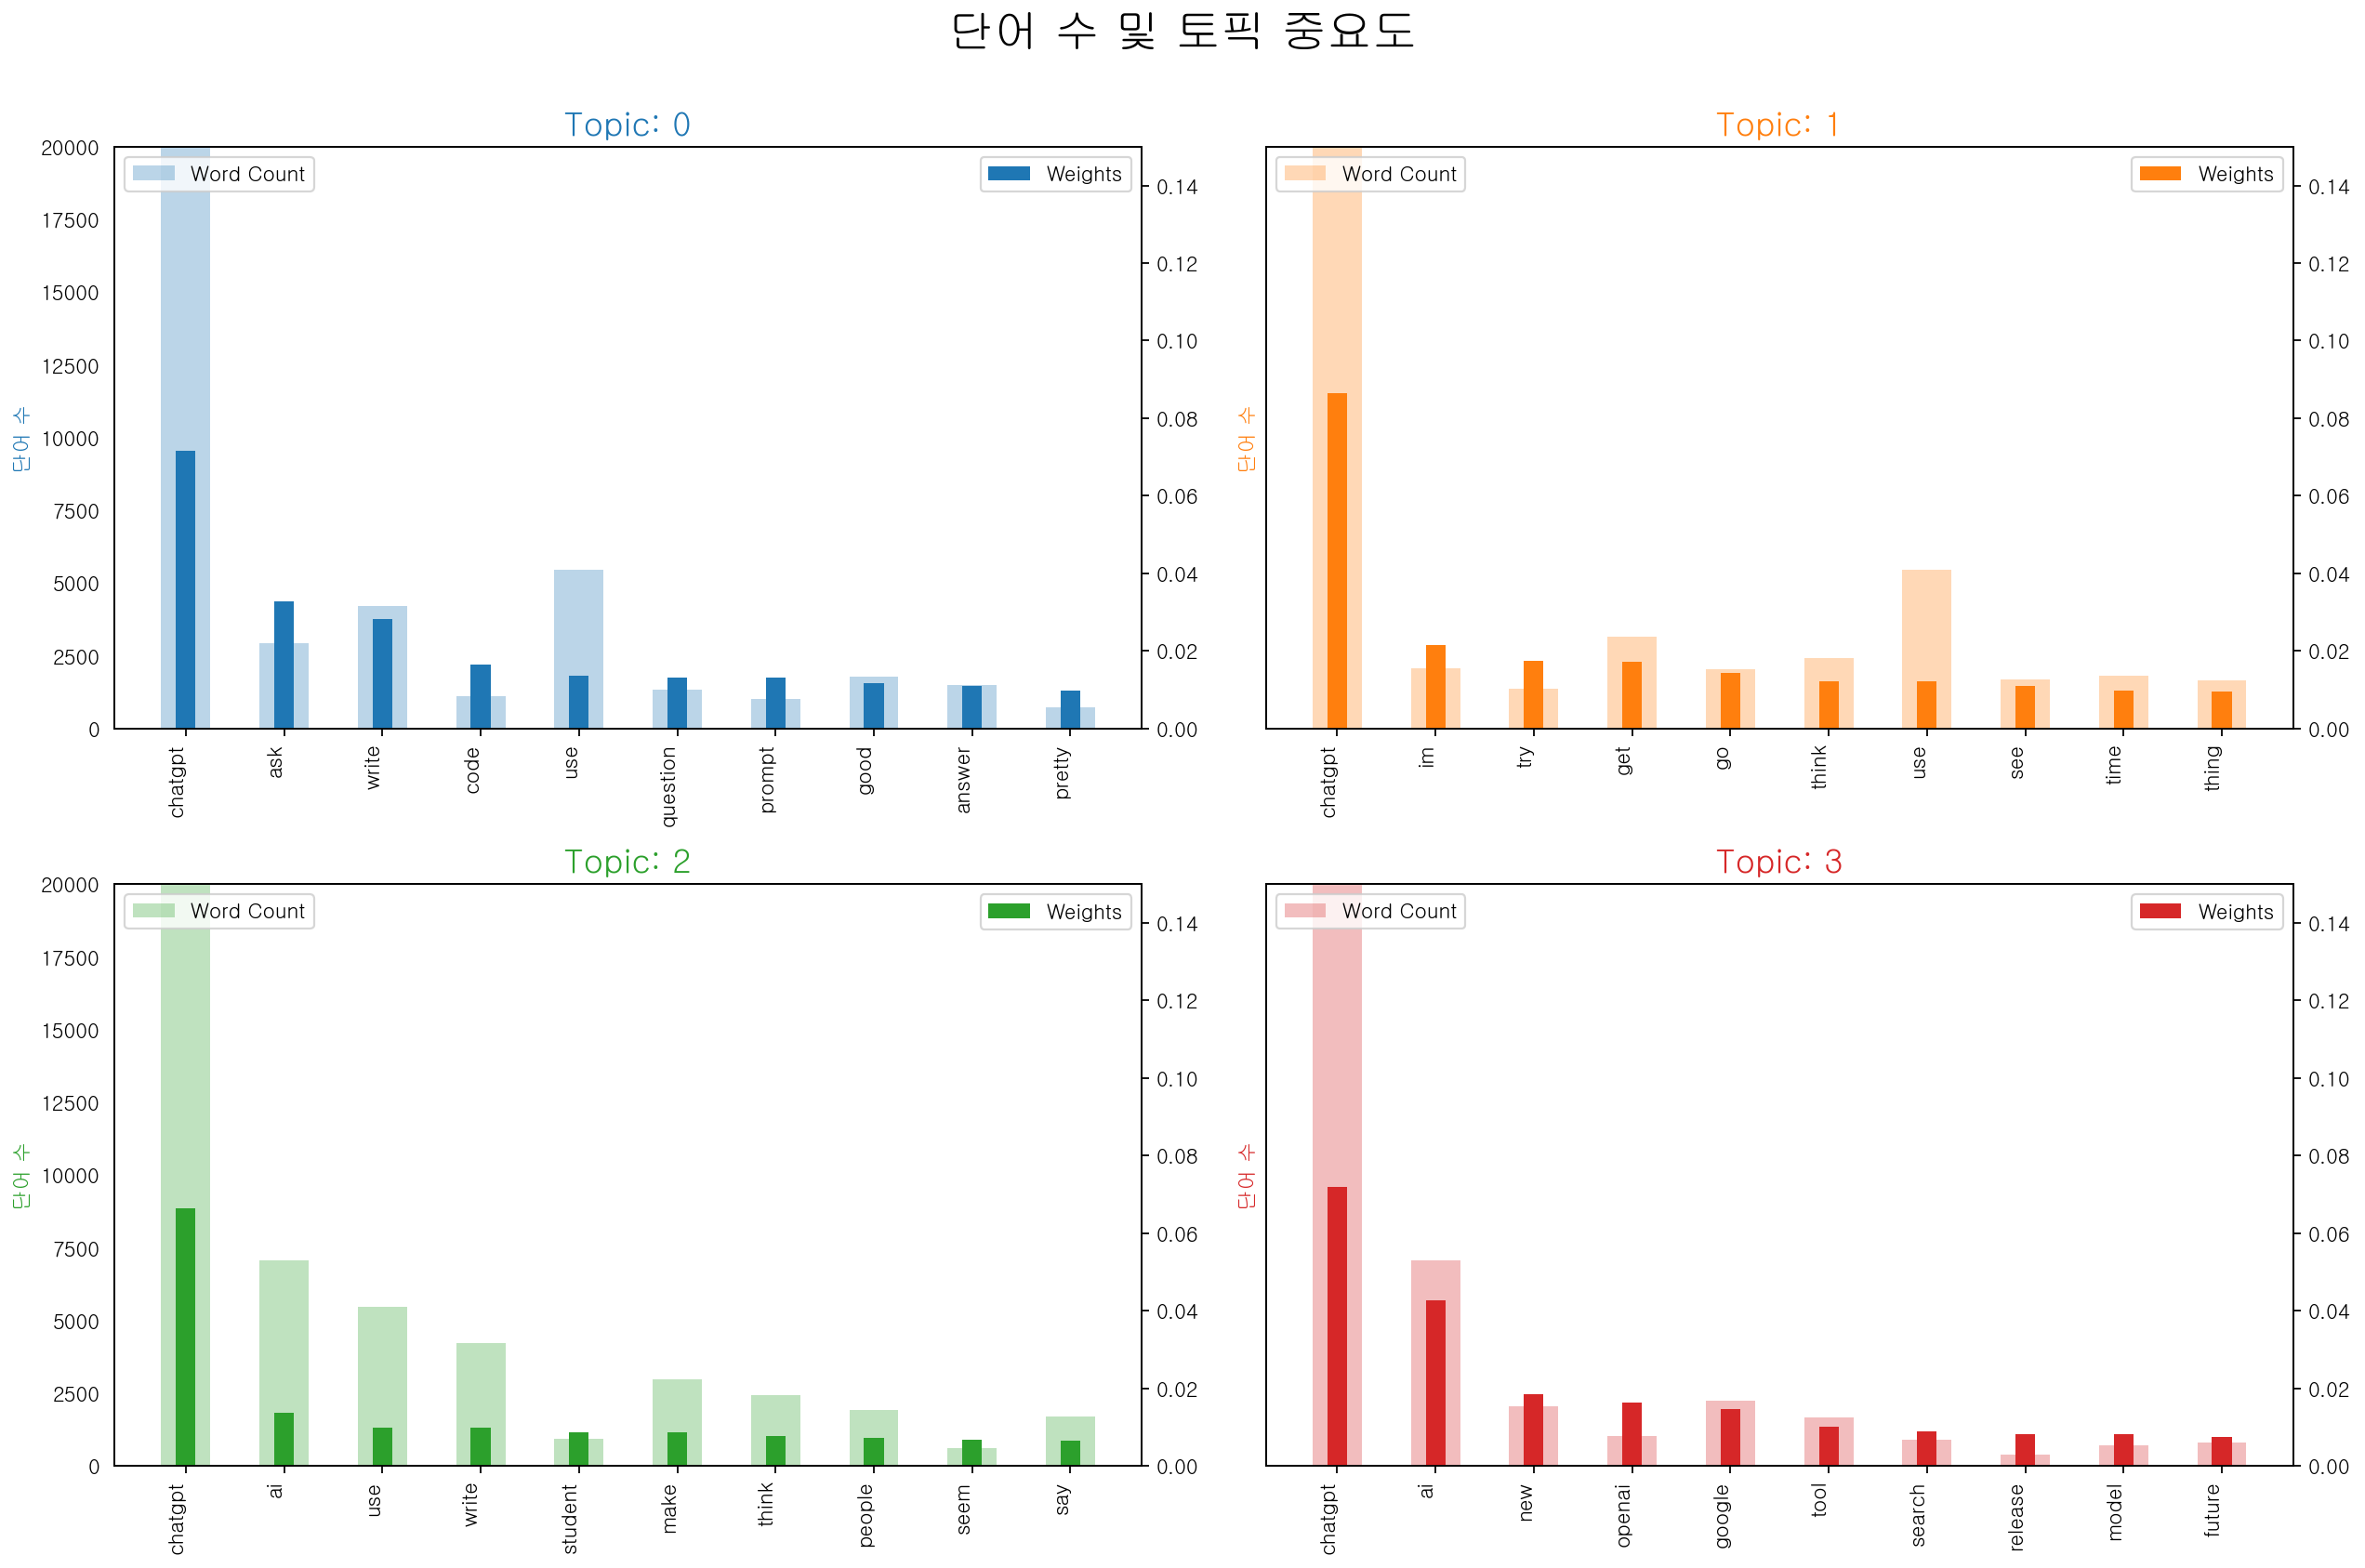

In [110]:
# 토픽의 단어 수와 Weights 시각화
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160) 
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()): 
    ax.bar(x='word', height="word_count", data=df2.loc[df2.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx() 
    ax_twin.bar(x='word', height="importance", data=df2.loc[df2.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('단어 수', color=cols[i]) 
    ax_twin.set_ylim(0, 0.15); 
    ax.set_ylim(0, 20000) 
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16) 
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df2.loc[df2.topic_id==i, 'word'], rotation=90, horizontalalignment= 'right')
    ax.legend(loc='upper left'); 
    ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('단어 수 및 토픽 중요도', fontsize=22, y=1.05)
plt.show()

시각화 해석  

각 토픽에서 중요한 단어들의 단어 빈도수(Word Count)와 토픽 내 가중치(Weights)를 비교한 것  

1. Topic 0: ChatGPT의 사용 방법과 관련된 토론  
2. Topic 1: ChatGPT에 대한 개인적인 경험과 감성  
3. Topic 2: ChatGPT의 교육적 활용 및 AI의 역할  
4. Topic 3: ChatGPT의 기술 발전과 OpenAI의 새로운 발표  

In [111]:
# LDA 모델의 퍼플렉서티(Perplexity) 점수를 계산하기 위한 함수 정의
def compute_perplexity_values(dictionary, corpus, k_values, passes_list): 
    results = []
    for num_topics in k_values:  # 다양한 토픽 수를 사용하여 반복
        for passes in passes_list:  # 패스 수를 달리하여 반복
            # LDA 모델 학습
            lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=passes)
            # 퍼플렉서티 점수 계산
            perplexity_score = lda_model.log_perplexity(corpus) 
            results.append((num_topics, passes, perplexity_score)) 
            print(f"Topics: {num_topics}, Passes: {passes}, Perplexity: {perplexity_score:.4f}") 
    return results

In [112]:
# 토픽 수와 패스 범위
k_values = range(2, 6, 2)	# Number of topics (2, 4, 6, 8)
passes_list = [10, 20, 30]	# Passes

# 퍼플렉서티 점수를 계산
results = compute_perplexity_values(dictionary, corpus, k_values, passes_list)

Topics: 2, Passes: 10, Perplexity: -7.3086
Topics: 2, Passes: 20, Perplexity: -7.2888
Topics: 2, Passes: 30, Perplexity: -7.2780
Topics: 4, Passes: 10, Perplexity: -7.3978
Topics: 4, Passes: 20, Perplexity: -7.3741
Topics: 4, Passes: 30, Perplexity: -7.3620


퍼플렉서티(Perplexity): 언어 모델 성능 예측 평가 지표  
모델이 단어를 예측하는 데 얼마나 불확실한지를 측정  
낮을수록 모델의 예측이 정확  

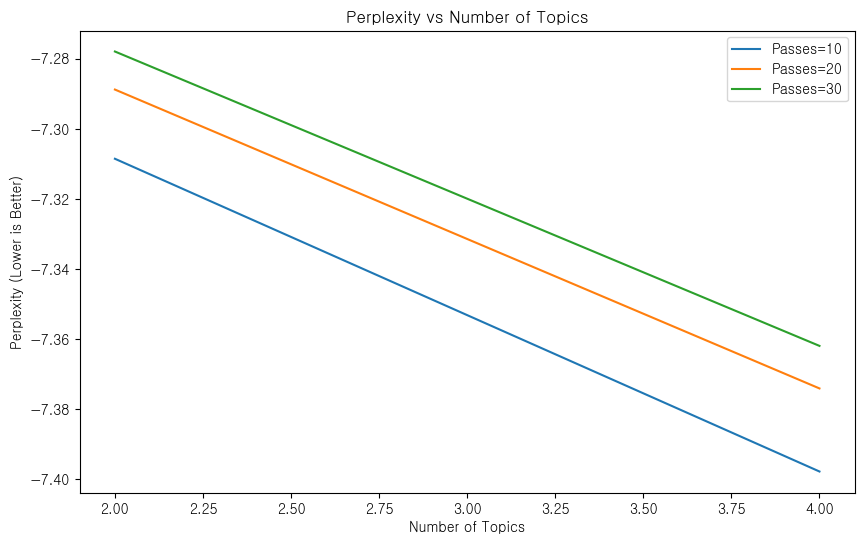

In [113]:
# 퍼플렉서티 점수 계산 결과 시각화
results_df = pd.DataFrame(results, columns=["Num_Topics", "Passes", "Perplexity"])

plt.figure(figsize=(10, 6)) 
for passes in passes_list:
    subset = results_df[results_df["Passes"] == passes] 
    plt.plot(subset["Num_Topics"], subset["Perplexity"], label=f'Passes={passes}') 
plt.title('Perplexity vs Number of Topics') 
plt.xlabel('Number of Topics') 
plt.ylabel('Perplexity (Lower is Better)') 
plt.legend()
plt.show()

In [114]:
# 일관성 점수와 퍼플렉서티 점수를 결합하여 최적의 토픽 수를 찾는 함수 정의
def compute_combined_score(dictionary, corpus, texts, k_values, passes_list): 
    results = []
    coherence_scores = []
    perplexity_scores = []

    for num_topics in k_values:
        for passes in passes_list:
            # LDA 모델 학습
            lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=passes)
            # 일관성 점수 계산
            coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence = coherence_model.get_coherence()
            coherence_scores.append(coherence)

            # 퍼플렉서티 점수 계산
            perplexity = lda_model.log_perplexity(corpus)
            perplexity_scores.append(perplexity)
            results.append((num_topics, passes, coherence, perplexity))
            print(f"Topics: {num_topics}, Passes: {passes}, Coherence: {coherence:.4f}, Perplexity: {perplexity:.4f}")

    # 일관성 점수와 퍼플렉서티 점수를 정규화하여 결합 점수 계산
    coherence_array = np.array(coherence_scores).reshape(-1, 1)
    perplexity_array = np.array(perplexity_scores).reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_coherence = scaler.fit_transform(coherence_array).flatten()
    normalized_perplexity = scaler.fit_transform(-perplexity_array).flatten()

    # 결합 점수 계산 (일관성 점수와 퍼플렉서티 점수의 평균)
    combined_scores = 0.5 * normalized_coherence + 0.5 * normalized_perplexity
    for i, (num_topics, passes, coherence, perplexity) in enumerate(results):
        results[i] += (combined_scores[i],)  # 결합 점수 추가

    return results

In [115]:
# 토픽 수와 패스 범위 정의
k_values = range(2, 6, 2)
passes_list = [10, 20, 30]

# 결합 점수를 계산
results = compute_combined_score(dictionary, corpus, documents, k_values, passes_list)

Topics: 2, Passes: 10, Coherence: 0.3892, Perplexity: -7.3086
Topics: 2, Passes: 20, Coherence: 0.3962, Perplexity: -7.2888
Topics: 2, Passes: 30, Coherence: 0.3962, Perplexity: -7.2780
Topics: 4, Passes: 10, Coherence: 0.4258, Perplexity: -7.3978
Topics: 4, Passes: 20, Coherence: 0.4202, Perplexity: -7.3741
Topics: 4, Passes: 30, Coherence: 0.4211, Perplexity: -7.3620


In [116]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results, columns=["Num_Topics", "Passes", "Coherence", "Perplexity", "Combined_Score"])

# 최적 매개변수 설정
topics_max_idx = results_df['Combined_Score'].idxmax()
optimal_params = results_df.loc[topics_max_idx]
print("Optimal Parameters:")
print(optimal_params)

Optimal Parameters:
Num_Topics         4.000000
Passes            10.000000
Coherence          0.425848
Perplexity        -7.397803
Combined_Score     1.000000
Name: 3, dtype: float64


일관성 점수와 퍼플렉서티 점수를 평균내서 계산    
단순히 퍼플렉서티가 가장 낮은 모델이 아니라 일관성과 퍼플렉서티의 균형이 좋은 모델을 선택

In [117]:
# 최적의 LDA 모델 생성
optimal_num_topics = optimal_params['Num_Topics']
optimal_passes = optimal_params['Passes']
final_lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=int(optimal_num_topics), passes=int(optimal_passes), random_state=42)

# LDA 모델 시각화
pyLDAvis.enable_notebook()
lda_visualization = pyLDAvis.gensim.prepare(final_lda_model, corpus, dictionary)
pyLDAvis.display(lda_visualization)

# 감성 분석 및 예측 모델 생성

목표: 트윗 데이터를 기반으로 감성이 긍정인지 부정인지 예측하는 모델을 구축  
기존 데이터를 바탕으로 토픽 모델링이 잘 되었는가 확인

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [119]:
# 감성 레이블 정의
df = df[df['predicted_label'].notnull()]
df['label'] = df['predicted_label'].map({'negative': 0, 'positive': 1})

# 필요 없는 컬럼 제거 -> 텍스트 데이터('cleaned_text')와 레이블('label'), 날짜('date')만 사용
df = df[['cleaned_text', 'label', 'date']]

# 데이터 불균형 확인
print("클래스 분포:")
print(df['label'].value_counts())

클래스 분포:
label
1    18574
0    13502
Name: count, dtype: int64


In [120]:
# 텍스트 데이터 벡터화 (TF-IDF 변환)
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = vectorizer.fit_transform(df['cleaned_text'])

In [121]:
# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df['label'], test_size=0.2, random_state=42, stratify=df['label'])


In [122]:
# 모델 학습 (랜덤 포레스트)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 예측 수행
y_pred = clf.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8189
              precision    recall  f1-score   support

           0       0.81      0.74      0.78      2701
           1       0.82      0.87      0.85      3715

    accuracy                           0.82      6416
   macro avg       0.82      0.81      0.81      6416
weighted avg       0.82      0.82      0.82      6416



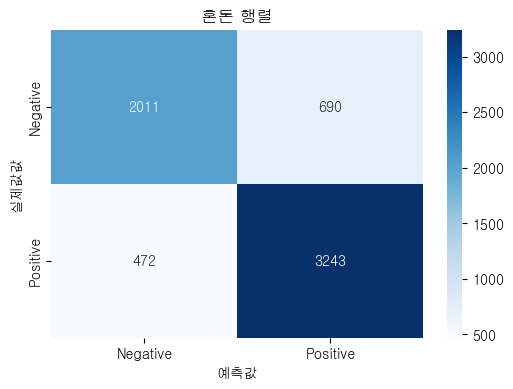

In [123]:
# 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('예측값')
plt.ylabel('실제값값')
plt.title('혼돈 행렬')
plt.show()

690개의 부정 감성이 긍정으로 잘못 분류  
472개의 긍정 감성이 부정으로 잘못 분류  
전체적으로 모델의 성능이 높은 편이지만 부정 감성과 긍정 감성을 혼동하는 사례가 존재

In [124]:
# 가장 중요한 단어 출력 (TF-IDF 기준)
feature_names = vectorizer.get_feature_names_out()
feature_importances = np.mean(tfidf_features.toarray(), axis=0)

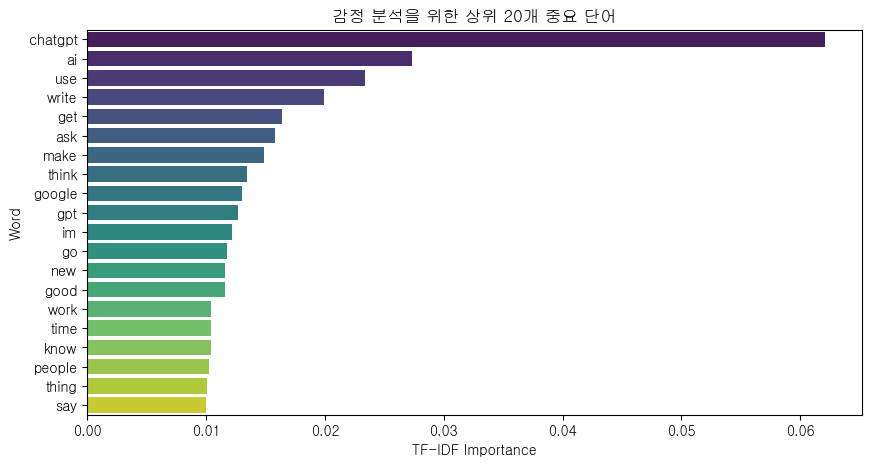

In [125]:
# 중요 단어 상위 20개 시각화
important_words = pd.DataFrame({'word': feature_names, 'importance': feature_importances})
important_words = important_words.sort_values(by='importance', ascending=False).head(20)
plt.figure(figsize=(10, 5))
sns.barplot(data=important_words, x='importance', y='word', palette='viridis')
plt.title('감정 분석을 위한 상위 20개 중요 단어')
plt.xlabel('TF-IDF Importance')
plt.ylabel('Word')
plt.show()

chatgpt, ai, use, write, get, ask 등이 주요 감성 관련 키워드  
new, work, time, people 등의 단어도 감성 분석에서 중요한 역할  
chatgpt와 ai 관련 언급이 많으며, write, ask 등의 단어가 감성 분석에 영향   
부정 감성은 problem, error 같은 단어와 연관될 가능성이 높음  
감성 예측 모델이 보다 정확한 감성 분류를 하도록 특정 단어의 가중치를 조정할 필요가 있어보임

In [126]:
# 감성 변화 분석 (시간에 따른 감성 변화 시각화)
df['date'] = df['date'].dt.date  # 날짜 단위로 변환하여 그룹화
sentiment_trend = df.groupby(['date', 'label']).size().unstack().fillna(0)

<Figure size 1200x600 with 0 Axes>

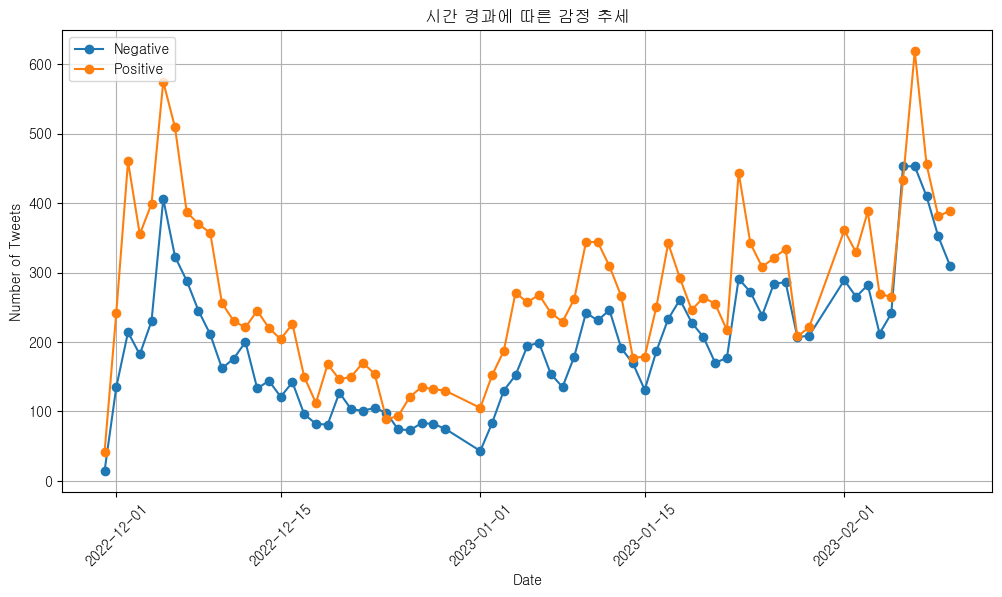

In [127]:
# 감성 변화 시각화
plt.figure(figsize=(12, 6))
sentiment_trend.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('시간 경과에 따른 감정 추세')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend(['Negative', 'Positive'])
plt.xticks(rotation=45)
plt.grid()
plt.show()

특정 시점에서 감성 변화(긍정/부정)를 추적하여 패턴을 분석    
12월 초 감성이 급격히 증가하며 부정 감성도 동반 상승  
1월 초 다시 감성 급변 긍정 감성이 상대적으로 높음  
2월 초 감성 변동이 심하며 새로운 이슈가 발생했을 가능성  

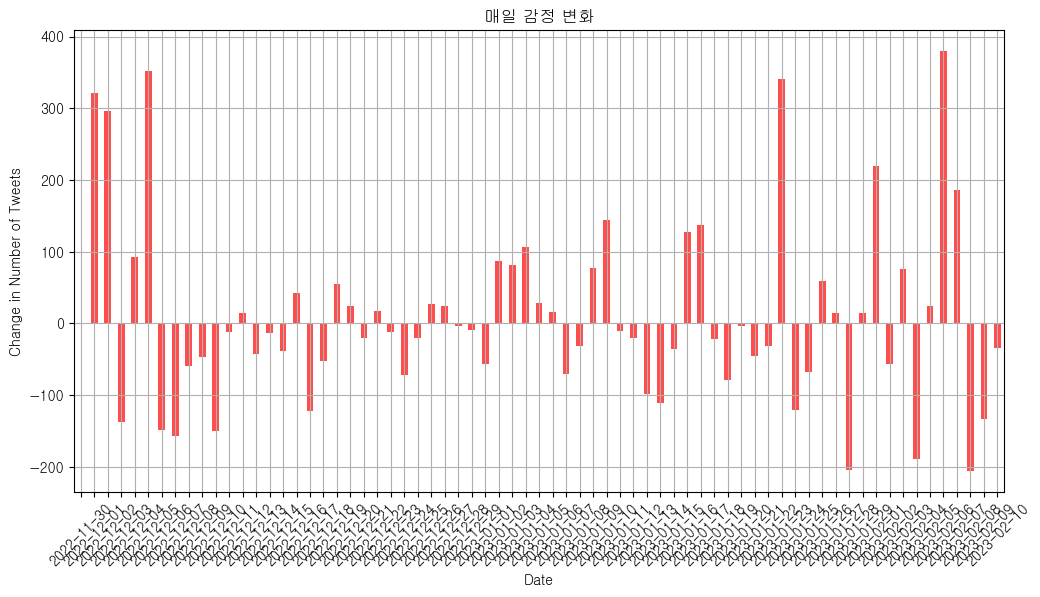

In [128]:
# 특정 시점에서 감성이 급격히 변하는지 탐색
sentiment_trend['change'] = sentiment_trend.sum(axis=1).diff()
plt.figure(figsize=(12, 6))
sentiment_trend['change'].plot(kind='bar', color='red', alpha=0.7)
plt.title('매일 감정 변화')
plt.xlabel('Date')
plt.ylabel('Change in Number of Tweets')
plt.xticks(rotation=45)
plt.grid()
plt.show()


일일 감성 변화량을 분석하여 감성이 급격히 변하는 시점을 파악

## 추가 분석 과제? 및 문제점

1. 전처리 함수 부분에서 stop word로 chatgpt 등을 제외하는 코드를 사용하였음에도 나타나는 이유는?
2. 모델 성능 개선 부분
3. 모델의 성능은 높지만 잘못 예측한 사례가 많은 이유는?
4. 랜덤 포레스트 모델 제외 다른 모델의 성능은?